# D209 PA 2 code - Doug Haunsperger

## Data Preparation

### Do initial package import and data read

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

SEED=1219

df = pd.read_csv('medical_clean.csv')

#view first 5 rows
df.head(5)

,CaseOrder,Customer_id,Interaction,UID,City,State,County,Zip,Lat,Lng,...,TotalCharge,Additional_charges,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
0,1,C412403,8cd49b13-f45a-4b47-a2bd-173ffa932c2f,3a83ddb66e2ae73798bdf1d705dc0932,Eva,AL,Morgan,35621,34.34960,-86.72508,...,3726.702860,17939.403420,3,3,2,2,4,3,3,4
1,2,Z919181,d2450b70-0337-4406-bdbb-bc1037f1734c,176354c5eef714957d486009feabf195,Marianna,FL,Jackson,32446,30.84513,-85.22907,...,4193.190458,17612.998120,3,4,3,4,4,4,3,3
2,3,F995323,a2057123-abf5-4a2c-abad-8ffe33512562,e19a0fa00aeda885b8a436757e889bc9,Sioux Falls,SD,Minnehaha,57110,43.54321,-96.63772,...,2434.234222,17505.192460,2,4,4,4,3,4,3,3
3,4,A879973,1dec528d-eb34-4079-adce-0d7a40e82205,cd17d7b6d152cb6f23957346d11c3f07,New Richland,MN,Waseca,56072,43.89744,-93.51479,...,2127.830423,12993.437350,3,5,5,3,4,5,5,5
4,5,C544523,5885f56b-d6da-43a3-8760-83583af94266,d2f0425877b10ed6bb381f3e2579424a,West Point,VA,King William,23181,37.59894,-76.88958,...,2113.073274,3716.525786,2,1,3,3,5,3,4,3


## Section C2 - Data Set Variables
### Selecting variables to answer research question

For possible explanatory variables, I am casting a wide net, looking at demographic info as well as reported medical conditions. LASSO regression should minimize or eliminate the impact of variables that do not affect the target.

In [2]:
# Target variable
target='Additional_charges'
# Quantitative explanatory
quant_cols=['Population', 'Children', 'Age', 'Income', 'VitD_levels']
#, 'Doc_visits', 'Initial_days', 'Full_meals_eaten', 'vitD_supp'] - these were not chosen because they would not be available at admission time

# Categorical explanatory
cat_cols = ['Gender', 'Marital', 'Soft_drink', 'HighBlood', 'Complication_risk', 'Overweight', 'Arthritis', 'Diabetes', 'Hyperlipidemia', 
            'Stroke', 'BackPain', 'Anxiety', 'Allergic_rhinitis', 'Reflux_esophagitis', 'Asthma', 'Initial_admin']

ind_var_cols = quant_cols + cat_cols

## Section C1 - Data Preprocessing
### Check for outliers

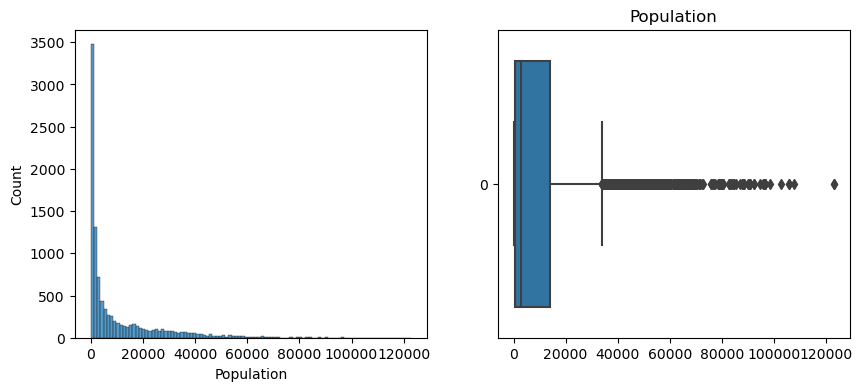

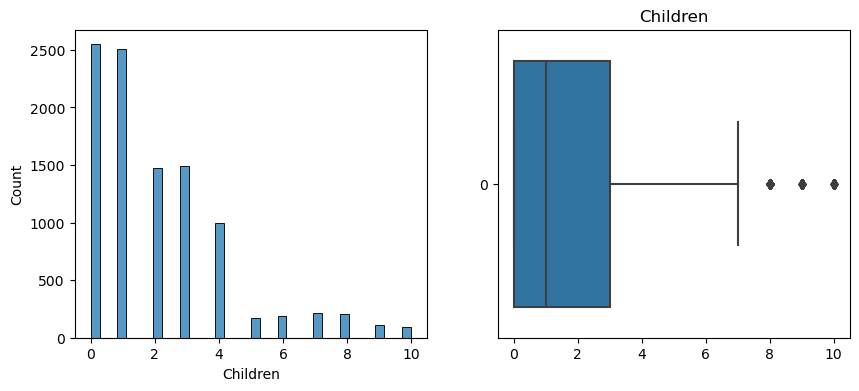

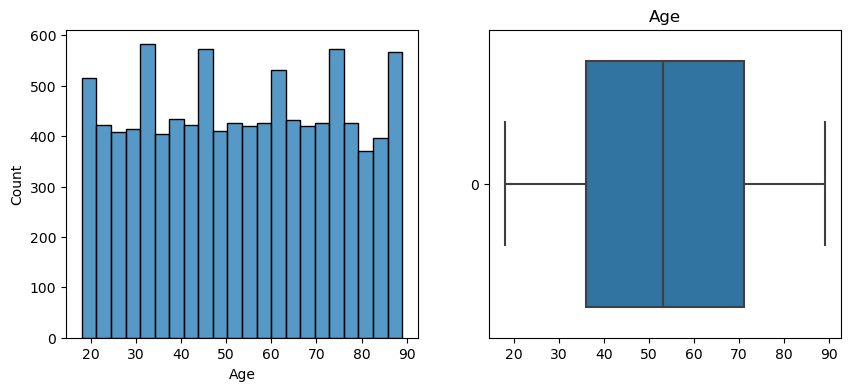

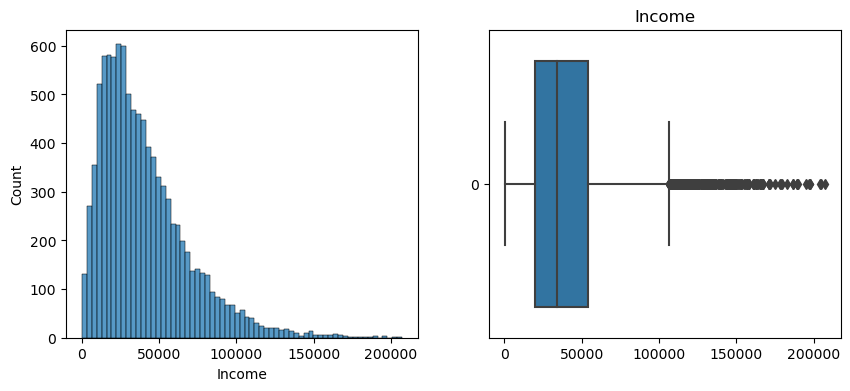

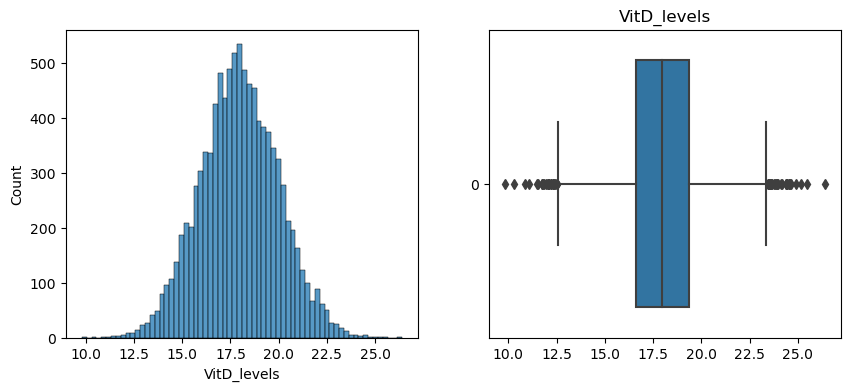

In [3]:
# Choose only the quantitative columns

# Ref: https://stackoverflow.com/questions/16392921/make-more-than-one-chart-in-same-ipython-notebook-cell (Kassies, 2013)
for col in quant_cols:
    fig, axs = plt.subplots(1,2, figsize=(10,4))
    sns.histplot(df[col], ax=axs[0])
    plt.title(col)
    sns.boxplot(df[col], orient='h', ax=axs[1])
    plt.title(col)
    plt.show()

The right-skewed distributions `Population` and `Income` might benefit from a log-scale analysis

C:\Users\dough\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


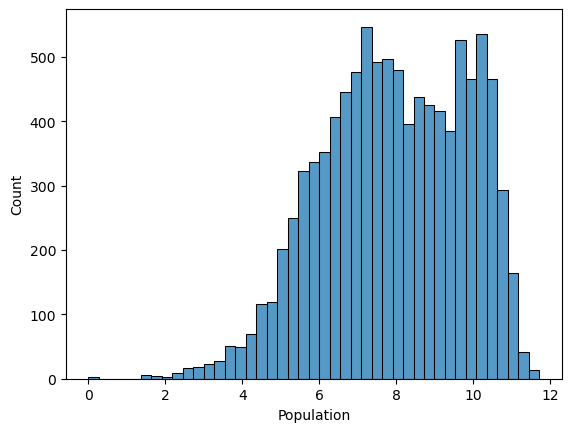

C:\Users\dough\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

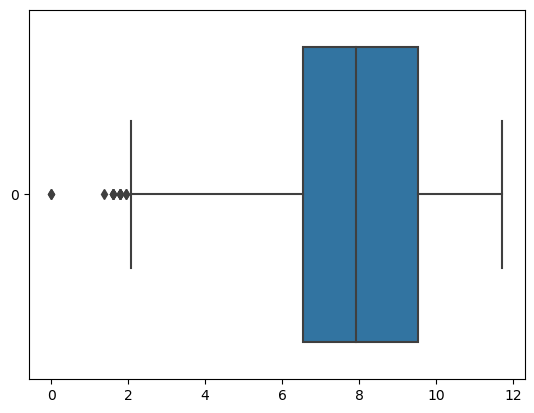

In [4]:
sns.histplot(np.log(df.Population))
plt.show()
sns.boxplot(np.log(df.Population), orient='h')

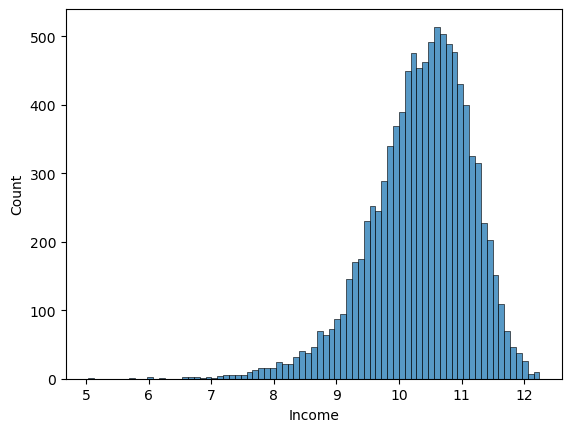

<Axes: >

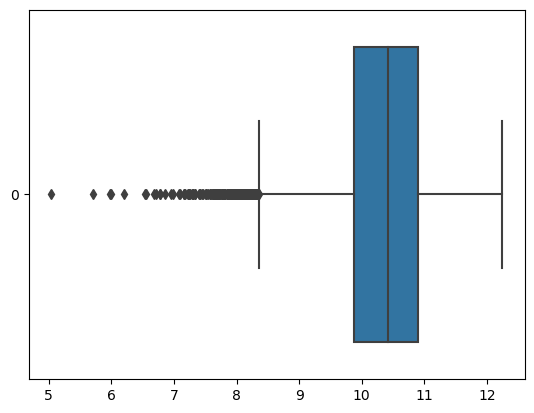

In [5]:
sns.histplot(np.log(df.Income))
plt.show()
sns.boxplot(np.log(df.Income), orient='h')

## Section C3 - Data Preparation / Transformation
### Treating Outliers
I will use the same treatment methodologies I did with the data in D208. In this case, I choose to retain all outliers except 0 values for `Population`, and `Income` below $3000/year

#### Population
Population is reasonable to have a long-tail, right-skew distribution. However, zero values are not reasonable. They would also interfere with doing a log transformation if necessary.

In [6]:
df[(df.Population == 0)].shape

(109, 50)

Removing `Population == 0` outliers from the data set and move them to a separate data frame

In [7]:
pop_outliers = df[(df.Population == 0)]
df.drop(df[(df.Population == 0)].index, inplace=True)
df.shape

(9891, 50)

#### Income
Income is reasonable to have a long-tail, right-skew distribution - values above \$200k per year are possible. However, the log transform shows a long-tail, left-skew distribution. `Income` below \$3000/year - or below approximately 8 on the log chart - will be removed under the assumption that these may have incorrectly been entered as monthly incomes rather than annual.

In [8]:
df[(df.Income < 3000)].shape

(105, 50)

Removing low `Income` outliers from the data set and move them to a separate data frame

In [9]:
inc_outliers = df[(df.Income < 3000)]
df.drop(df[(df.Income < 3000)].index, inplace=True)
df.shape

(9786, 50)

### Re-expressing Categorical Variables

In [10]:
# Split the data into features (X) and target (y)

# target variable dataframe
y = df[target].copy(deep=True)
# possible explanatory variables
X = df[ind_var_cols].copy(deep=True)

for col in cat_cols:
    print(df[col].unique())

['Male' 'Female' 'Nonbinary']
['Divorced' 'Married' 'Widowed' 'Never Married' 'Separated']
['No' 'Yes']
['Yes' 'No']
['Medium' 'High' 'Low']
['No' 'Yes']
['Yes' 'No']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['Yes' 'No']
['Yes' 'No']
['Yes' 'No']
['No' 'Yes']
['Yes' 'No']
['Emergency Admission' 'Elective Admission' 'Observation Admission']


Set up dictionaries based on the above unique values in the data set. Code adapted from Section 3.6 of Larose & Larose (2019). `Gender`, `Marital`, and `Initial_admin` will be handled in the next code block.

In [11]:
dict_compl = {"Low": 1, "Medium": 2, "High": 3}
dict_yn = {"Yes": 1, "No": 0}
replace_dict = {'Soft_drink': dict_yn, 'HighBlood': dict_yn, 'Stroke': dict_yn, 'Complication_risk':dict_compl, 'Overweight': dict_yn,
                'Arthritis': dict_yn, 'Diabetes': dict_yn, 'Hyperlipidemia': dict_yn, 'BackPain': dict_yn, 'Anxiety': dict_yn, 
                'Allergic_rhinitis': dict_yn, 'Reflux_esophagitis': dict_yn, 'Asthma': dict_yn}
X.replace(replace_dict, inplace = True)
print(X.head())
#y.replace(dict_yn, inplace = True)
#y.head()

   Population  Children  Age    Income  VitD_levels  Gender        Marital  \
0        2951         1   53  86575.93    19.141466    Male       Divorced   
1       11303         3   51  46805.99    18.940352  Female        Married   
2       17125         3   53  14370.14    18.057507  Female        Widowed   
3        2162         0   78  39741.49    16.576858    Male        Married   
5         981         3   76  81999.88    19.612646    Male  Never Married   

   Soft_drink  HighBlood  Complication_risk  ...  Arthritis  Diabetes  \
0           0          1                  2  ...          1         1   
1           0          1                  3  ...          0         0   
2           0          1                  2  ...          0         1   
3           0          0                  2  ...          1         0   
5           0          0                  2  ...          1         1   

   Hyperlipidemia  Stroke  BackPain  Anxiety  Allergic_rhinitis  \
0               0       0

Set up dummy one-hot variables for `Gender`, `Marital` & `Initial_admin`. 
Per Dr. Middleton, using k-1 columns via the drop_first parameter in order to mitigate multicollinearity (2022). In this case, 'Divorced' is represented by 0's in all `Marital_*` columns. Similarly, 'Elective Admission' is represented by 0's in all `Initial_admin_*` columns.

In [12]:
X = pd.get_dummies(X, columns=['Gender', 'Marital', 'Initial_admin'], drop_first=True)
# replace column names in cat_cols list
cat_cols.remove('Gender')
cat_cols.remove('Marital')
cat_cols.remove('Initial_admin')
for col in ['Gender_Male', 'Gender_Nonbinary', 'Marital_Married', 'Marital_Never Married', 'Marital_Separated', 'Marital_Widowed', 
                'Initial_admin_Emergency Admission', 'Initial_admin_Observation Admission'] :
    cat_cols.append(col)



### Logarithmic Transformations
I showed above that taking the log of `Population` and `Income` provide more normally-distributed populations.  I will replace these columns in the model data with the log othe original values.

In [13]:
X['Population'] = np.log(X.Population)
X['Income'] = np.log(X.Income)
X.rename(columns={'Population': 'logPop', 'Income': 'logIncome'}, inplace=True)

# Replace names in quant_cols list
quant_cols=['logPop', 'Children', 'Age', 'logIncome', 'VitD_levels'] #, 'Doc_visits', 'Initial_days', 'vitD_supp', 'Full_meals_eaten']

ind_var_cols = quant_cols + cat_cols

X.head()

,logPop,Children,Age,logIncome,VitD_levels,Soft_drink,HighBlood,Complication_risk,Overweight,Arthritis,...,Reflux_esophagitis,Asthma,Gender_Male,Gender_Nonbinary,Marital_Married,Marital_Never Married,Marital_Separated,Marital_Widowed,Initial_admin_Emergency Admission,Initial_admin_Observation Admission
0,7.989899,1,53,11.368777,19.141466,0,1,2,0,1,...,0,1,1,0,0,0,0,0,1,0
1,9.332823,3,51,10.753766,18.940352,0,1,3,1,0,...,1,0,0,0,1,0,0,0,1,0
2,9.748295,3,53,9.572908,18.057507,0,1,2,1,0,...,0,0,0,0,0,0,0,1,0,0
3,7.678789,0,78,10.590151,16.576858,0,0,2,0,1,...,1,1,1,0,1,0,0,0,0,0
5,6.888572,3,76,11.314473,19.612646,0,0,2,1,1,...,0,0,1,0,0,1,0,0,0,1


## Section C4
### Output clean data set

In [14]:
df_out = pd.concat([y, X], axis=1)

df_out.to_csv('lasso_clean_medical_data.csv', index=False)

## Section D1
### Split the data into training/testing

In [15]:
# Code ref: Kirenz tutorial (2021)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

## Section D2 - Data Analysis

#### Scale quantitative variables

In [16]:
# Scale only the quantitative features using StandardScaler / ColumnTransformer
# code ref: scikit-learn User Guide, section 6.1.4


scaler = ColumnTransformer(
        [('scl', StandardScaler(), quant_cols)], remainder="drop")


#Transform training/test data
X_train[quant_cols] = scaler.fit_transform(X_train)
X_test[quant_cols] = scaler.transform(X_test)

print(X_train.head())
print(y_train.head())

        logPop  Children       Age  logIncome  VitD_levels  Soft_drink  \
8929 -0.638627  0.884202  1.529785  -0.129063     1.011802           0   
3208 -0.685303 -0.973554 -1.518166   0.526087    -1.357321           0   
271   0.586009 -0.509115  1.626546   0.667167     0.093686           1   
6996  0.951148  0.419763 -0.985984  -0.290782     0.362740           0   
5881 -1.495704 -0.044676  1.674926   1.180004    -1.038648           0   

      HighBlood  Complication_risk  Overweight  Arthritis  ...  \
8929          0                  3           1          0  ...   
3208          0                  2           0          0  ...   
271           1                  3           1          0  ...   
6996          0                  3           1          1  ...   
5881          1                  2           0          1  ...   

      Reflux_esophagitis  Asthma  Gender_Male  Gender_Nonbinary  \
8929                   1       0            0                 0   
3208                   0

### LASSO Regressor Fit & Evaluate
Start with arbitrary alpha of 1. Also instantiate an OLS model for comparison.

In [17]:
ols=LinearRegression()
_ = ols.fit(X_train, y_train)

# Code ref: (Kirenz, 2021)

reg = Lasso(alpha=1)
_ = reg.fit(X_train, y_train)

In [18]:
print('OLS R squared training set: {:5f}'.format(ols.score(X_train, y_train)))
print('OLS R squared test set: {:5f}'.format(ols.score(X_test, y_test)))
print()
print('Initial LASSO R squared training set: {:5f}'.format(reg.score(X_train, y_train)))
print('Initial LASSO R squared test set: {:5f}'.format(reg.score(X_test, y_test)))

OLS R squared training set: 0.938324
OLS R squared test set: 0.938494

Initial LASSO R squared training set: 0.938320
Initial LASSO R squared test set: 0.938520


In [19]:
# OLS Training data MSE
y_pred_ols_train = ols.predict(X_train)
mse_ols_train = mean_squared_error(y_train, y_pred_ols_train)
print('OLS MSE training set: {:.4e}'.format(mse_ols_train))

# OLS Test data MSE
y_pred_ols_test = reg.predict(X_test)
mse_ols_test = mean_squared_error(y_test, y_pred_ols_test)
print('OLS MSE test set: {:.4e}'.format(mse_ols_test))

print()
# Training data MSE
y_pred_train = reg.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
print('Initial LASSO MSE training set: {:.4e}'.format(mse_train))

# Test data MSE
y_pred_test = reg.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
print('Initial LASSO MSE test set: {:.4e}'.format(mse_test))

OLS MSE training set: 2.6270e+06
OLS MSE test set: 2.6751e+06

Initial LASSO MSE training set: 2.6272e+06
Initial LASSO MSE test set: 2.6751e+06


#### Choose best hyperparameter α

In [20]:
# Find best α using cross-validation - code ref: (Kirenz, 2021); (scikit API, LassoCV, 2023)
alphas = np.logspace(-2,2,10000)
model = LassoCV(cv=5, alphas=alphas, selection='random', random_state=SEED)
model.fit(X_train, y_train)
print('Best alpha: {:.3f}'.format(model.alpha_))
#print(model.alphas_)

Best alpha: 8.067


#### Plot MSE vs α curve for model

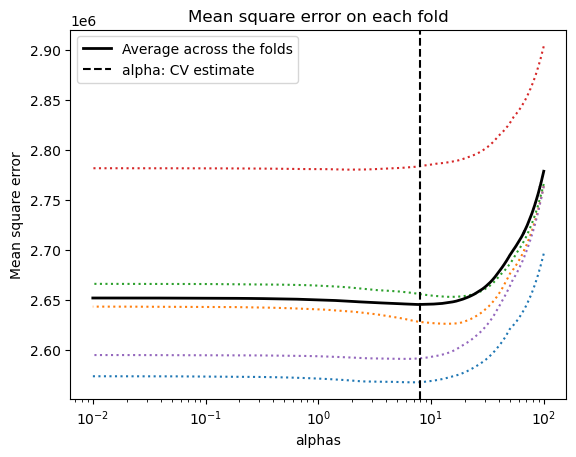

In [21]:
#Code ref: (Kirenz, 2021).
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")
plt.show()


## Section E1 - Evaluation 
#### Calculate R<sup>2</sup>, MSE for LASSO using best α

In [22]:
bestLasso = Lasso(alpha=model.alpha_)
_ = bestLasso.fit(X_train, y_train)

print('Best LASSO R squared training set: {:5f}'.format(bestLasso.score(X_train, y_train)))
print('Best LASSO R squared test set: {:5f}'.format(bestLasso.score(X_test, y_test)))
print('OLS R squared test set: {:5f}'.format(ols.score(X_test, y_test)))
print()

# Training data MSE
y_pred_train = bestLasso.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
print('Best LASSO MSE training set: {:.4e}'.format(mse_train))

# Test data MSE
y_pred_test = bestLasso.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
print('Best LASSO MSE test set: {:.4e}'.format(mse_test))
print('OLS MSE test set: {:.4e}'.format(mse_ols_test))
print()
print('Mean target value (y-bar): {:.0f}'.format(np.mean(y)))
print('Best LASSO RMSE: {:.0f}'.format(mse_test**0.5))


Best LASSO R squared training set: 0.938223
Best LASSO R squared test set: 0.938562
OLS R squared test set: 0.938494

Best LASSO MSE training set: 2.6313e+06
Best LASSO MSE test set: 2.6732e+06
OLS MSE test set: 2.6751e+06

Mean target value (y-bar): 12946
Best LASSO RMSE: 1635


### Reduced coefficients

In [23]:
#Code refs: (Kirenz, 2021; Bengtsson, 2013).
print('Coefficients in OLS model:')
[print(line) for line in sorted(list(zip(ols.coef_, X)), key=lambda x: (abs(x[0]), x[1]), reverse=True)]
print()
print('Coefficients in Best LASSO model:')
[print(line2) for line2 in sorted(list(zip(bestLasso.coef_, X)), key=lambda x: (abs(x[0]), x[1]), reverse=True)]
print()

Coefficients in OLS model:
(8608.613250878576, 'HighBlood')
(4654.369026173942, 'Age')
(466.69100552927364, 'Initial_admin_Emergency Admission')
(335.7423742214914, 'Stroke')
(250.9280262911699, 'Complication_risk')
(181.86478578230617, 'Gender_Male')
(-101.63463699684416, 'Initial_admin_Observation Admission')
(99.14169133842198, 'Marital_Never Married')
(-89.18314593180995, 'Arthritis')
(57.931482706289124, 'Gender_Nonbinary')
(55.959409868316534, 'Soft_drink')
(50.65415162785037, 'Marital_Widowed')
(48.417436501004005, 'logPop')
(42.99165998737678, 'Marital_Married')
(38.223729282528794, 'Asthma')
(36.670288941258214, 'Overweight')
(33.04356551118851, 'Children')
(27.68160327206548, 'Reflux_esophagitis')
(-27.417433494789954, 'VitD_levels')
(-25.305470126215955, 'BackPain')
(22.052314785898645, 'Anxiety')
(8.05442334390675, 'Allergic_rhinitis')
(-6.986132554463393, 'logIncome')
(4.299075662694251, 'Diabetes')
(0.96129808703725, 'Hyperlipidemia')
(0.1773311866765706, 'Marital_Separat

In [24]:
# Output test / train data

df_train_out = pd.concat([y_train, X_train], axis=1)
df_test_out = pd.concat([y_test, X_test], axis=1)
df_test_preds = pd.concat([y_test, pd.DataFrame(y_pred_test, index=y_test.index, columns=['Predictions'])], axis=1)

_=df_train_out.to_csv('lasso_train_medical_data.csv', index=False)
_=df_test_out.to_csv('lasso_test_medical_data.csv', index=False)
_=df_test_preds.to_csv('lasso_testpreds_medical_data.csv')

